In [1072]:
# Load the data and libraries
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
from scipy.special import expit as invlogit

data = pd.read_csv('./data/Free throw.csv.zip').drop('Timestamp', axis=1)
data.columns = ['age', 'gender', 'athleticism', 'y0', 'y1']

true_effect = data.y1 - data.y0
y0 = data.y0
y1 = data.y1
x = data.athleticism
n = len(data)

# Create fake data
np.random.seed(42)
n = 1000
x = np.random.randint(1, 11, size=n)
y1 = np.random.binomial(50, invlogit(0.2 * x - 1.5))
y0 = np.random.binomial(50, invlogit(0.2 * x - 2.0))
data = pd.DataFrame({"x": x, "y1": y1, "y0": y0})

true_effect = data.y1 - data.y0

print(f'True ATE for all respondents {true_effect.mean():.2f} with an sd of {true_effect.std():.2f}')


True ATE for all respondents 5.19 with an sd of 4.58


In [938]:
### Assign random treatment

z = np.random.binomial(1, 0.5, size=n)
y = np.where(z == 1, y1, y0)

est = np.mean(y[z == 1]) - np.mean(y[z == 0])
s1 = np.std(y[z == 1], ddof=1)
s0 = np.std(y[z == 0], ddof=1)
n1 = np.sum(z == 1)
n0 = np.sum(z == 0)
se = np.sqrt(s1**2 / n1 + s0**2 / n0)

print(f'Random treatment ATE {est:.2f} with SE of {se:.2f}')

Random treatment ATE 5.34 with SE of 0.45


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]
/Users/tarmo/miniforge3/envs/salk/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Output()

/Users/tarmo/miniforge3/envs/salk/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


<Axes: title={'center': 'beta'}>

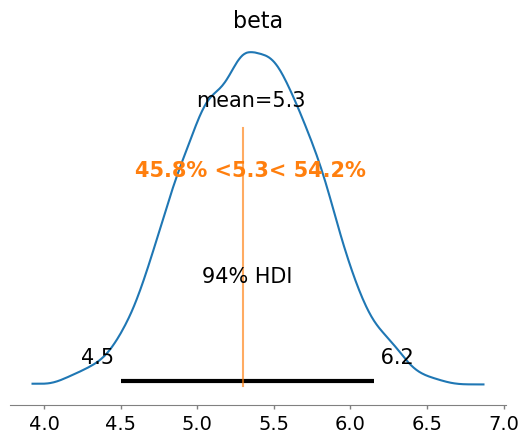

In [939]:
## Next let's estimate it using a model

with pm.Model() as model:
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=10)
    #sigma = pm.HalfCauchy("sigma", beta=5)
    # Changed sigma prior to HalfNormal that has thinner tail and therefore shrinks signma towards zero
    sigma = pm.HalfNormal("sigma", sigma=5)  

    mu = alpha + beta * z
    likelihood = pm.Normal("y", mu=mu, sigma=sigma, observed=y)

    trace = pm.sample()

pm.summary(trace)
pm.plot_posterior(trace, var_names=["beta"], ref_val=5.3)

(array([ 21.,  86., 340., 758., 951., 956., 599., 220.,  56.,  13.]),
 array([3.9221532 , 4.21711557, 4.51207794, 4.80704031, 5.10200268,
        5.39696505, 5.69192742, 5.98688979, 6.28185216, 6.57681453,
        6.8717769 ]),
 <BarContainer object of 10 artists>)

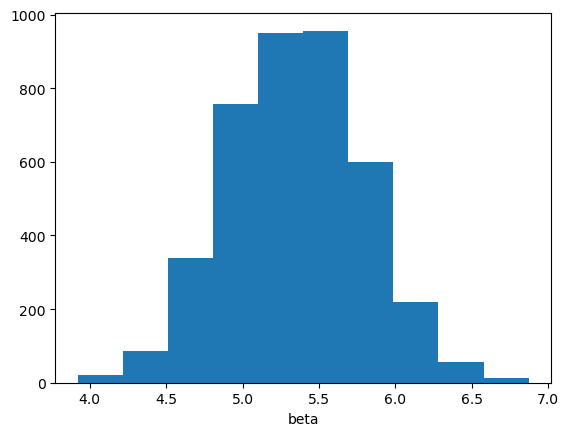

In [943]:
trace.posterior.beta.plot.hist()

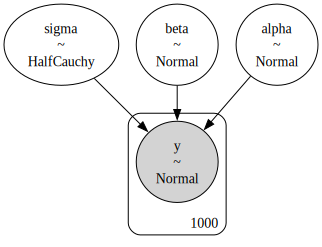

In [38]:
pm.model_to_graphviz(model)

In [944]:
### Add dias

p_treat = invlogit(x - 5.5)
z = np.random.binomial(1, p_treat)
y = np.where(z == 1, y1, y0)

# Estimating the ATE with the same model gives biased estimate:

with pm.Model() as model:
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=10)
    sigma = pm.HalfNormal("sigma", sigma=5)

    mu = alpha + beta * z
    likelihood = pm.Normal("y", mu=mu, sigma=sigma, observed=y)

    trace = pm.sample()

pm.summary(trace)



Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]
/Users/tarmo/miniforge3/envs/salk/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,10.577,0.229,10.155,11.015,0.005,0.003,1910.0,2447.0,1.0
beta,14.784,0.323,14.201,15.397,0.007,0.005,1874.0,2384.0,1.0
sigma,5.117,0.116,4.897,5.332,0.002,0.002,3010.0,2606.0,1.0


In [945]:
# In order to correct the bias we stratify with treatment

with pm.Model() as model:
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta_z = pm.Normal("beta_z", mu=0, sigma=10)
    beta_x = pm.Normal("beta_x", mu=0, sigma=10)
    sigma = pm.HalfNormal("sigma", sigma=5)

    mu = alpha + beta_z * z + beta_x * x
    likelihood = pm.Normal("y", mu=mu, sigma=sigma, observed=y)

    trace = pm.sample()

pm.summary(trace)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_z, beta_x, sigma]
/Users/tarmo/miniforge3/envs/salk/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Output()

/Users/tarmo/miniforge3/envs/salk/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,3.794,0.236,3.337,4.220,0.005,0.004,1845.0,1977.0,1.0
beta_x,2.106,0.055,1.998,2.204,0.001,0.001,1632.0,1981.0,1.0
beta_z,5.391,0.320,4.799,5.989,0.007,0.005,2064.0,2240.0,1.0
sigma,3.268,0.074,3.134,3.407,0.001,0.001,2543.0,2228.0,1.0


array([<Axes: title={'center': 'alpha'}>,
       <Axes: title={'center': 'beta_x'}>,
       <Axes: title={'center': 'beta_z'}>,
       <Axes: title={'center': 'sigma'}>], dtype=object)

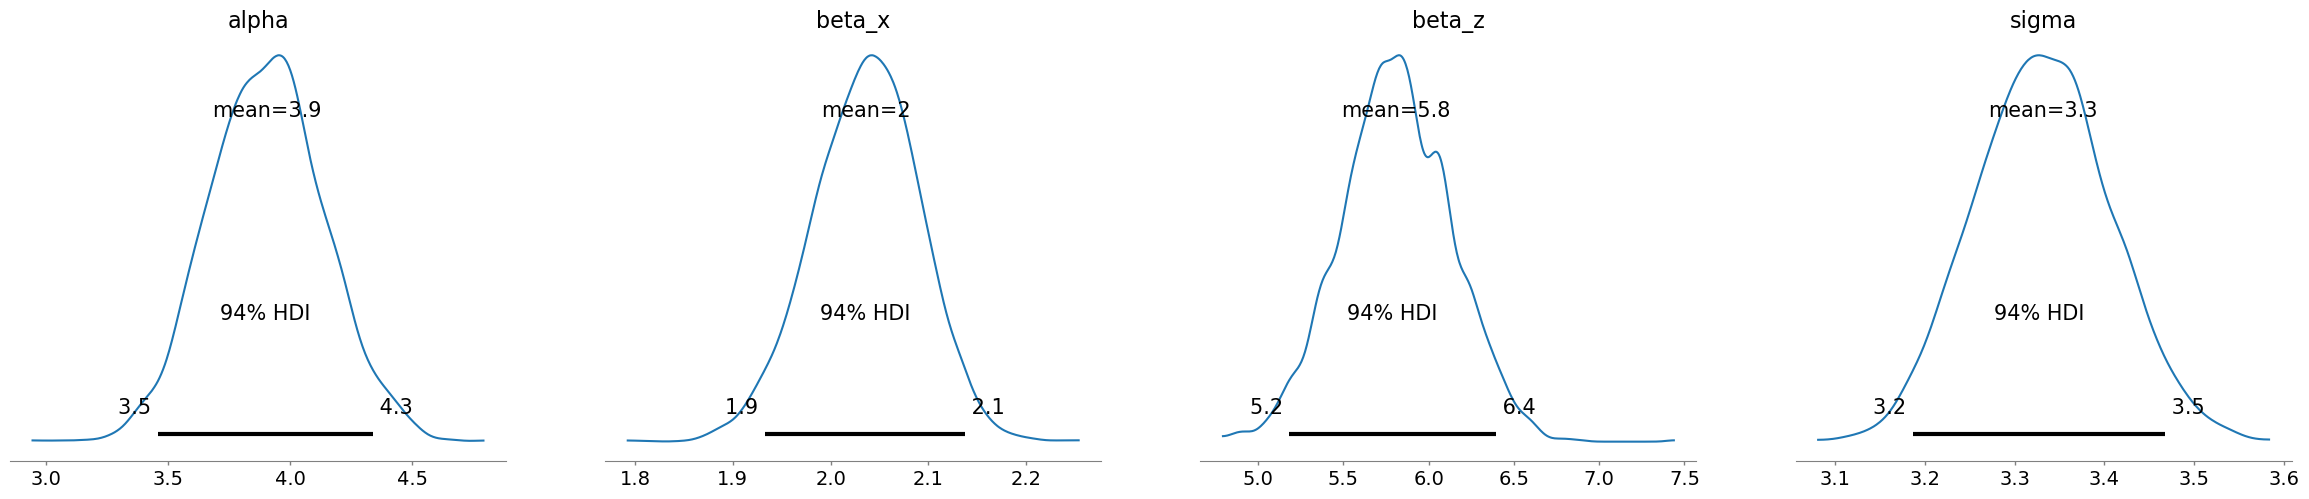

In [14]:
pm.plot_posterior(trace)

In [57]:
# Biased in the other direction

p_treat = invlogit(-(x - 5.5))
z = np.random.binomial(1, p_treat)
y = np.where(z == 1, y1, y0)

# Estimate the ATE with a model

with pm.Model() as model3:
    ...

### Our own dataset

OK, we have established that with the fake data our model behaves as expected. Let's next try again with the 17 observations that we gathered in the class, but now we set the seed for np.random that will keep treatment assignments fixed between different runs.

In [1073]:
np.random.seed(42)

data = pd.read_csv('./data/Free throw.csv.zip').drop('Timestamp', axis=1)
data.columns = ['age', 'gender', 'athleticism', 'y0', 'y1']

print(data.head())

true_effect = data.y1 - data.y0
y0 = data.y0
y1 = data.y1
x = data.athleticism
n = len(data)

print(f'True ATE for all respondents {true_effect.mean():.2f} with an sd of {true_effect.std():.2f}')

   age  gender  athleticism  y0  y1
0   24    Male            2  10  25
1   21    Male            7   3  15
2   28    Male            8  15  25
3   39    Male            7  10  40
4   31  Female            6  15  20
True ATE for all respondents 12.82 with an sd of 7.26


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


<Axes: title={'center': 'beta'}>

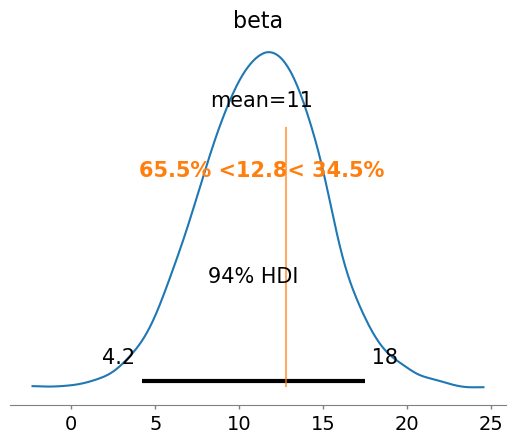

In [233]:
# Assign random treatment
z = np.random.binomial(1, 0.5, size=n)
y = np.where(z == 1, y1, y0)

with pm.Model() as model:
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=10)
    sigma = pm.HalfCauchy("sigma", beta=5)
    # Changed sigma prior to HalfNormal that has thinner tail and therefore shrinks signma towards zero
    #sigma = pm.HalfNormal("sigma", sigma=5)  

    mu = alpha + beta * z
    likelihood = pm.Normal("y", mu=mu, sigma=sigma, observed=y)

    trace = pm.sample()

pm.summary(trace)
pm.plot_posterior(trace, var_names=["beta"], ref_val=12.8)

In [43]:
# Next we add bias and run the same model that should give us much more optimistic estimate of the ETA

np.random.seed(42)

p_treat = invlogit(x - 5.5)
z = np.random.binomial(1, p_treat)
y = np.where(z == 1, y1, y0)

# Estimating the ATE with the same model gives biased estimate:

with pm.Model() as model:
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=10)
    sigma = pm.HalfNormal("sigma", sigma=5)

    mu = alpha + beta * z
    likelihood = pm.Normal("y", mu=mu, sigma=sigma, observed=y)

    trace = pm.sample()

pm.summary(trace)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,7.647,2.446,3.134,12.390,0.059,0.046,1699.0,1847.0,1.0
beta,19.125,3.327,12.833,25.474,0.083,0.060,1604.0,2027.0,1.0
sigma,7.068,1.212,4.991,9.316,0.025,0.021,2320.0,2277.0,1.0


In [946]:
# Now let's debiase our data - which should return beta_z closter to the true value

with pm.Model() as model:
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta_z = pm.Normal("beta_z", mu=0, sigma=10)
    beta_x = pm.Normal("beta_x", mu=0, sigma=10)
    sigma = pm.HalfNormal("sigma", sigma=5)

    mu = alpha + beta_z * z + beta_x * x
    likelihood = pm.Normal("y", mu=mu, sigma=sigma, observed=y)

    trace = pm.sample()

pm.summary(trace)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_z, beta_x, sigma]
/Users/tarmo/miniforge3/envs/salk/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Output()

/Users/tarmo/miniforge3/envs/salk/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,3.797,0.230,3.385,4.250,0.005,0.004,1853.0,1975.0,1.0
beta_x,2.103,0.056,1.992,2.200,0.001,0.001,1548.0,1599.0,1.0
beta_z,5.410,0.327,4.799,6.016,0.007,0.007,1977.0,2245.0,1.0
sigma,3.266,0.073,3.124,3.397,0.001,0.001,2889.0,2654.0,1.0


### Yay, it worked! :)

In [949]:
with pm.Model() as model:
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta_z = pm.Normal("beta_z", mu=0, sigma=10)
    beta_x = pm.Normal("beta_x", mu=0, sigma=10)

    # Poisson distribution expects a positive rate parameter (lambda)
    lambda_ = pm.math.exp(alpha + beta_z * z + beta_x * x)
    
    # Changing the likelihood to Poisson
    likelihood = pm.Poisson("y", mu=lambda_, observed=y)

    trace = pm.sample()

pm.summary(trace)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_z, beta_x]
/Users/tarmo/miniforge3/envs/salk/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Output()

/Users/tarmo/miniforge3/envs/salk/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,1.947,0.021,1.909,1.986,0.001,0.000,1524.0,1578.0,1.01
beta_x,0.120,0.004,0.112,0.127,0.000,0.000,1523.0,1483.0,1.00
beta_z,0.341,0.025,0.298,0.389,0.001,0.001,1733.0,1978.0,1.00


In [954]:
with model:
    pp = pm.sample_posterior_predictive(trace)

pp.posterior_predictive.y.mean()

Sampling: [y]


Output()

<xarray.DataArray 'y' ()> Size: 8B
array(17.956552)

In [953]:
y.mean()

17.955

In [70]:
# Simulated data
N = 17
ability = np.random.randint(1, 11, size=N)  # Ability score from 1 to 10
treatment = np.random.randint(0, 2, size=N)  # Randomly assign treatment (0=control, 1=treatment)
y0 = np.random.binomial(50, ability / 20)  # Baseline performance
y1 = y0 + treatment * np.random.randint(1, 10, size=N)  # Post-treatment performance with improvement

# Model
with pm.Model() as model:
    # Hyperpriors for ability effect
    mu_ability = pm.Normal("mu_ability", mu=0, sigma=10)
    sigma_ability = pm.HalfNormal("sigma_ability", sigma=10)

    # Individual ability effects
    ability_effect = pm.Normal("ability_effect", mu=mu_ability, sigma=sigma_ability, shape=N)

    # Baseline probability (logit link)
    theta0 = pm.Deterministic("theta0", pm.math.sigmoid(ability_effect))

    # Treatment effect (ATE)
    ate = pm.Normal("ate", mu=0, sigma=5)

    # Outcome probability (logit link)
    theta1 = pm.Deterministic("theta1", pm.math.sigmoid(ability_effect + ate * treatment))

    # Observed data
    y0_obs = pm.Binomial("y0_obs", n=50, p=theta0, observed=y0)
    y1_obs = pm.Binomial("y1_obs", n=50, p=theta1, observed=y1)

    # Inference
    trace = pm.sample(2000, return_inferencedata=True)

# Posterior summary
az.summary(trace, var_names=["ate"])

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_ability, sigma_ability, ability_effect, ate]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
ate,0.603,0.141,0.334,0.867,0.002,0.001,7167.0,6750.0,1.0


In [80]:
d = pd.DataFrame({'ability': ability, 'treatment': treatment, 'y0': y0, 'y1':y1})
print('ATE: ', (d[d.treatment==1].y1-d[d.treatment==1].y0).mean())

ATE:  5.818181818181818


In [92]:
treat = d.treatment==1
d[treat].y0.sum() / d[treat].y1.sum()

0.6862745098039216

In [93]:
with pm.Model() as model:
    # Poisson prior for baseline performance (expected number of successes)
    lambda0 = pm.Poisson("lambda0", mu=25, shape=N)  # Prior centered around 25/50 successes

    # Treatment effect on *additional number of successes*
    ate_count = pm.Poisson("ate_count", mu=5)  # Prior for treatment effect (in counts)

    # Expected post-treatment successes
    lambda1 = pm.Deterministic("lambda1", lambda0 + ate_count * treatment)

    # Observed data: Binomial likelihood
    y0_obs = pm.Binomial("y0_obs", n=50, p=lambda0 / 50, observed=y0)
    y1_obs = pm.Binomial("y1_obs", n=50, p=lambda1 / 50, observed=y1)

    # Inference
    trace = pm.sample(2000, return_inferencedata=True)

# Posterior summary
az.summary(trace, var_names=["ate_count"])

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [lambda0]
>Metropolis: [ate_count]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
ate_count,2.17,1.01,1.0,4.0,0.032,0.018,1023.0,1400.0,1.0


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.


<Axes: title={'center': 'beta'}>

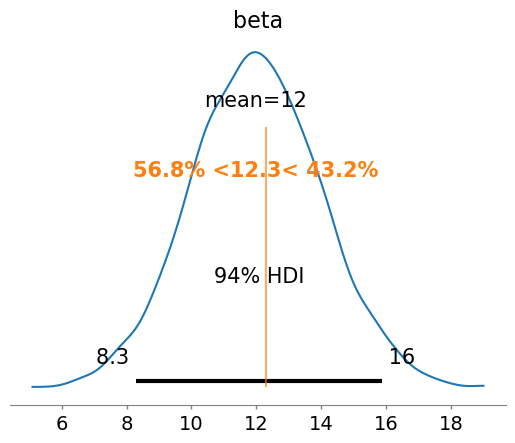

In [103]:
import pytensor.tensor as pt

with pm.Model() as model:
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=10)
    #sigma = pm.HalfCauchy("sigma", beta=5)
    # Changed sigma prior to HalfNormal that has thinner tail and therefore shrinks signma towards zero
    sigma = pm.HalfNormal("sigma", sigma=5)  

    mu = pt.math.maximum(0.001,alpha + beta * z)
    likelihood = pm.Poisson("y", mu=mu, observed=y)

    trace = pm.sample()

pm.summary(trace)
pm.plot_posterior(trace, var_names=["beta"], ref_val=12.3)

In [95]:
pm.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
ability_effect[0],-1.503,0.250,-1.974,-1.045,0.002,0.003,18463.0,5905.0,1.0
ability_effect[1],0.115,0.206,-0.272,0.505,0.002,0.002,15510.0,6056.0,1.0
ability_effect[2],-3.024,0.422,-3.833,-2.263,0.004,0.005,12771.0,6408.0,1.0
ability_effect[3],0.034,0.207,-0.367,0.407,0.002,0.002,14741.0,7051.0,1.0
ability_effect[4],-1.582,0.252,-2.088,-1.142,0.002,0.003,14849.0,5830.0,1.0
ability_effect[5],-0.606,0.206,-1.002,-0.228,0.002,0.003,17882.0,4906.0,1.0
ability_effect[6],-1.116,0.225,-1.547,-0.701,0.002,0.003,14963.0,6262.0,1.0
ability_effect[7],-0.522,0.206,-0.900,-0.137,0.001,0.003,19801.0,5650.0,1.0
ability_effect[8],-0.935,0.222,-1.354,-0.521,0.002,0.003,14913.0,5543.0,1.0
ability_effect[9],-0.761,0.214,-1.159,-0.358,0.002,0.003,14959.0,6583.0,1.0


In [107]:
data['y0s'] = data.y0 / 50
data['y1s'] = data.y1 / 50

data['te'] = data.y1s - data.y0s

print(data.te.mean())

data.head()

0.25647058823529406


,age,gender,athleticism,y0,y1,y0s,y1s,te
0,24,Male,2,10,25,0.20,0.5,0.30
1,21,Male,7,3,15,0.06,0.3,0.24
2,28,Male,8,15,25,0.30,0.5,0.20
3,39,Male,7,10,40,0.20,0.8,0.60
4,31,Female,6,15,20,0.30,0.4,0.10


In [116]:
data
    

,age,gender,athleticism,y0,y1,y0s,y1s,te
0,24,Male,2,10,25,0.20,0.50,0.30
1,21,Male,7,3,15,0.06,0.30,0.24
2,28,Male,8,15,25,0.30,0.50,0.20
3,39,Male,7,10,40,0.20,0.80,0.60
4,31,Female,6,15,20,0.30,0.40,0.10
5,24,Female,7,16,36,0.32,0.72,0.40
6,26,Female,6,15,25,0.30,0.50,0.20
7,36,Male,6,10,20,0.20,0.40,0.20
8,29,Female,3,8,22,0.16,0.44,0.28
9,27,Female,2,5,15,0.10,0.30,0.20


In [136]:
with pm.Model() as model:
    # Priors for baseline success rate
    alpha = pm.HalfNormal("alpha", sigma=2)
    beta = pm.HalfNormal("beta", sigma=2)

    # Baseline success rates
    p0 = pm.Beta("p0", alpha=alpha, beta=beta, shape=len(data))

    # Treatment effect (ATE) on success rate
    ate = pm.Normal("ate", mu=0, sigma=0.2)

    # Post-treatment success rates
    p1 = pm.Deterministic("p1", pm.math.clip(p0 + ate, 0, 1))

    # Likelihood: Binomial outcomes based on success rates
    y0_obs = pm.Binomial("y0_obs", n=50, p=p0, observed=data.y0)
    y1_obs = pm.Binomial("y1_obs", n=50, p=p1, observed=data.y1)

    # Inference
    trace = pm.sample()

# Posterior summary
az.summary(trace, var_names=["ate"])

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, p0, ate]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
ate,0.102,0.003,0.096,0.107,0.0,0.0,3615.0,3272.0,1.0


In [141]:

data['te'] =  (data.y1 - data.y0) / 50
data.te.mean()

0.10380000000000002

In [125]:
# true params
beta0_true = 0.7
beta1_true = 0.4
# number of yes/no questions
n = 20

sample_size = 30
x = np.linspace(-10, 20, sample_size)
# Linear model
mu_true = beta0_true + beta1_true * x
# transformation (inverse logit function = expit)
p_true = expit(mu_true)
# Generate data
y = rng.binomial(n, p_true)
# bundle data into dataframe
d = pd.DataFrame({"x": x, "y": y})

coords = {"observation": d.index.values}

with pm.Model(coords=coords) as binomial_regression_model:
    x = pm.ConstantData("x", d["x"], dims="observation")
    # priors
    beta0 = pm.Normal("beta0", mu=0, sigma=1)
    beta1 = pm.Normal("beta1", mu=0, sigma=1)
    # linear model
    mu = beta0 + beta1 * x
    p = pm.Deterministic("p", pm.math.invlogit(mu), dims="observation")
    # likelihood
    pm.Binomial("y", n=n, p=p, observed=d["y"], dims="observation")

    idata = pm.sample(1000, tune=2000)

pm.summary(idata)

/Users/tarmo/miniforge3/envs/salk/lib/python3.12/site-packages/pymc/data.py:235: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta0, beta1]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 1 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta0,0.443,0.149,0.150,0.712,0.002,0.002,3646.0,2971.0,1.0
beta1,0.435,0.037,0.370,0.510,0.001,0.001,3695.0,2655.0,1.0
p[0],0.021,0.008,0.008,0.035,0.000,0.000,3670.0,2595.0,1.0
p[1],0.032,0.010,0.015,0.053,0.000,0.000,3668.0,2644.0,1.0
p[2],0.049,0.014,0.025,0.076,0.000,0.000,3664.0,2702.0,1.0
p[3],0.074,0.018,0.041,0.108,0.000,0.000,3662.0,2664.0,1.0
p[4],0.110,0.023,0.068,0.153,0.000,0.000,3655.0,2773.0,1.0
p[5],0.162,0.028,0.111,0.213,0.000,0.000,3649.0,2783.0,1.0
p[6],0.232,0.033,0.171,0.291,0.001,0.001,3642.0,2727.0,1.0
p[7],0.320,0.035,0.251,0.383,0.001,0.001,3633.0,2625.0,1.0


In [135]:
data

,x,y1,y0
0,7,21,12
1,4,19,7
2,8,25,22
3,5,15,15
4,7,29,21
...,...,...,...
995,10,32,25
996,10,27,24
997,8,31,26
998,2,20,8


In [156]:
with pm.Model() as model:
    # Priors for baseline success rate
    alpha = pm.HalfNormal("alpha", sigma=2)
    beta = pm.HalfNormal("beta", sigma=2)

    # Baseline success rates
    p0 = pm.Beta("p0", alpha=alpha, beta=beta, shape=len(data))

    # ATE: Still using a Normal prior
    ate = pm.Normal("ate", mu=0, sigma=0.2)

    # Post-treatment success rates, only changed by treatment group
    p1 = pm.Deterministic("p1", pm.math.clip(p0 + ate * treatment, 0, 1))

    # Likelihood: Binomial outcomes based on success rates
    y0_obs = pm.Binomial("y0_obs", n=50, p=p0, observed=data.y0)
    y1_obs = pm.Binomial("y1_obs", n=50, p=p1, observed=data.y1)

    # Inference
    trace = pm.sample()

# Posterior summary
az.summary(trace, var_names=["ate"])

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, p0, ate]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
ate,0.06,0.023,0.018,0.102,0.0,0.0,3556.0,3082.0,1.0


In [154]:
# Assign random treatment
z = np.random.binomial(1, 0.5, size=n)
data['y'] = np.where(z == 1, data.y1, data.y0)



In [157]:
np.random.uniform(0.4, 0.8, size=N)

array([0.71005313, 0.77579958, 0.75793094, 0.63915999, 0.76874969,
       0.435397  , 0.47839314, 0.41809092, 0.53013213, 0.55547092,
       0.50853961, 0.731495  , 0.54270133, 0.5123738 , 0.61707843,
       0.45636969, 0.72087879])

In [158]:
df = data.copy()

import pymc as pm
import numpy as np
import arviz as az

# Transform the data
N = len(df)
y0 = df['y0'].values
y1 = df['y1'].values

# Model
with pm.Model() as model:
    # Priors for baseline success rate
    alpha = pm.HalfNormal("alpha", sigma=2)
    beta = pm.HalfNormal("beta", sigma=2)

    # Baseline success rates
    p0 = pm.Beta("p0", alpha=alpha, beta=beta, shape=N)

    # ATE: Using Normal prior
    ate = pm.Normal("ate", mu=0, sigma=0.2)

    # Post-treatment success rates
    p1 = pm.Deterministic("p1", pm.math.clip(p0 + ate, 0, 1))

    # Likelihood: Binomial outcomes based on success rates
    y0_obs = pm.Binomial("y0_obs", n=50, p=p0, observed=y0)
    y1_obs = pm.Binomial("y1_obs", n=50, p=p1, observed=y1)

    # Inference
    trace = pm.sample(2000, return_inferencedata=True)

# Posterior summary
az.summary(trace, var_names=["ate"])


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, p0, ate]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
ate,0.229,0.022,0.188,0.269,0.0,0.0,8073.0,7321.0,1.0


In [160]:
np.random.seed(52)  # For reproducibility
df['treatment'] = np.random.randint(0, 2, size=len(df))  # 0 = control, 1 = treated

# Extract data
N = len(df)
y0 = df['y0'].values
y1 = df['y1'].values
treatment = df['treatment'].values

# Model
with pm.Model() as model:
    # Priors for baseline success rate
    alpha = pm.HalfNormal("alpha", sigma=2)
    beta = pm.HalfNormal("beta", sigma=2)

    # Baseline success rates
    p0 = pm.Beta("p0", alpha=alpha, beta=beta, shape=N)

    # ATE: Using Normal prior
    ate = pm.Normal("ate", mu=0, sigma=0.2)

    # Post-treatment success rates, only adjusted for those in the treatment group
    p1 = pm.Deterministic("p1", pm.math.clip(p0 + ate * treatment, 0, 1))

    # Likelihood: Binomial outcomes based on success rates
    y0_obs = pm.Binomial("y0_obs", n=50, p=p0, observed=y0)
    y1_obs = pm.Binomial("y1_obs", n=50, p=p1, observed=y1)

    # Inference
    trace = pm.sample(2000, return_inferencedata=True)

# Posterior summary
az.summary(trace, var_names=["ate"])

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, p0, ate]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
ate,0.194,0.026,0.146,0.245,0.0,0.0,9264.0,6886.0,1.0


In [955]:
from scipy.special import expit  # expit is the sigmoid / invlogit function

# Compute treatment probability based on athleticism
df['p_treat'] = expit(df['athleticism'] - 5.5)

# Assign treatment based on p_treat
df['treatment'] = np.random.binomial(1, df['p_treat'])

# Extract data
N = len(df)
y0 = df['y0'].values
y1 = df['y1'].values
treatment = df['treatment'].values

# Model
with pm.Model() as model:
    # Priors for baseline success rate
    alpha = pm.HalfNormal("alpha", sigma=2)
    beta = pm.HalfNormal("beta", sigma=2)

    # Baseline success rates
    p0 = pm.Beta("p0", alpha=alpha, beta=beta, shape=N)

    # ATE: Using Normal prior
    ate = pm.Normal("ate", mu=0, sigma=0.2)

    # Post-treatment success rates, adjusted for treatment
    p1 = pm.Deterministic("p1", pm.math.clip(p0 + ate * treatment, 0, 1))

    # Likelihood: Binomial outcomes based on success rates
    y0_obs = pm.Binomial("y0_obs", n=50, p=p0, observed=y0)
    y1_obs = pm.Binomial("y1_obs", n=50, p=p1, observed=y1)

    # Inference
    trace = pm.sample(2000, return_inferencedata=True)

# Posterior summary
az.summary(trace, var_names=["ate"])


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, p0, ate]
/Users/tarmo/miniforge3/envs/salk/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Output()

/Users/tarmo/miniforge3/envs/salk/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
ate,0.268,0.027,0.216,0.317,0.0,0.0,8409.0,6543.0,1.0


In [958]:
with model:
    pp = pm.sample_posterior_predictive(trace)

diff = pp.posterior_predictive.y1_obs - pp.posterior_predictive.y0_obs 

Sampling: [y0_obs, y1_obs]


Output()

In [963]:
import pymc as pm
import numpy as np
import arviz as az

# Simulated data (replace with actual data)
n_obs = 1000
n_shots = 50

# Baseline free throw performance (number of successes out of 50)
baseline_successes = np.random.randint(8, 30, size=n_obs)

# Treatment assignment (0 = control, 1 = treatment)
treatment = np.random.randint(0, 2, size=n_obs)

# Post-treatment free throw performance (number of successes out of 50)
post_treatment_successes = baseline_successes + treatment * np.random.randint(-2, 15, size=n_obs)
post_treatment_successes = np.clip(post_treatment_successes, 0, n_shots)

# model
with pm.Model() as model:
    # Priors
    alpha = pm.Normal('alpha', mu=0, sigma=10)  
    beta = pm.Normal('beta', mu=0, sigma=10)   

    # Expected value of post-treatment performance
    mu = alpha + beta * treatment + baseline_successes / n_shots

    # Likelihood
    obs = pm.Binomial('obs', n=n_shots, p=pm.math.sigmoid(mu), observed=post_treatment_successes)

    # Inference
    trace = pm.sample(2000, tune=1000)

# ATE estimation in terms of difference in success ratio
alpha_samples = np.asarray(trace.posterior['alpha'])
beta_samples = np.asarray(trace.posterior['beta'])
p_control = pm.math.sigmoid(alpha_samples).eval()
p_treatment = pm.math.sigmoid(alpha_samples + beta_samples).eval()
success_ratio_diff = p_treatment - p_control

print(f"Estimated difference in success ratio: {success_ratio_diff.mean():.4f} ± {success_ratio_diff.std():.4f}")

# Convert probabilities to expected number of successes
shots_control = p_control * n_shots
shots_treatment = p_treatment * n_shots

# Difference in expected number of successful shots
success_shots_diff = shots_treatment - shots_control

print(f"Estimated difference in number of successful shots: {success_shots_diff.mean():.4f} ± {success_shots_diff.std():.4f}")


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]
/Users/tarmo/miniforge3/envs/salk/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Output()

/Users/tarmo/miniforge3/envs/salk/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.


Estimated difference in success ratio: 0.1176 ± 0.0041
Estimated difference in number of successful shots: 5.8781 ± 0.2073


Sampling: [obs]


Output()

<Axes: xlabel='obs'>

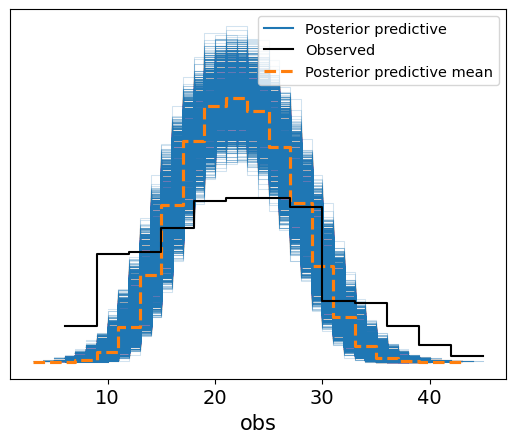

In [965]:
with model:
    pp = pm.sample_posterior_predictive(trace)

az.plot_ppc(pp)

In [970]:
pp.posterior_predictive.obs.mean()

<xarray.DataArray 'obs' ()> Size: 8B
array(21.64926588)

In [ ]:
d = pd.DataFrame({'y0': baseline_successes, 'y1': post_treatment_successes, 'z': treatment})

y = post_treatment_successes


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]
/Users/tarmo/miniforge3/envs/salk/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Output()

/Users/tarmo/miniforge3/envs/salk/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


Posterior mean of p: 0.36


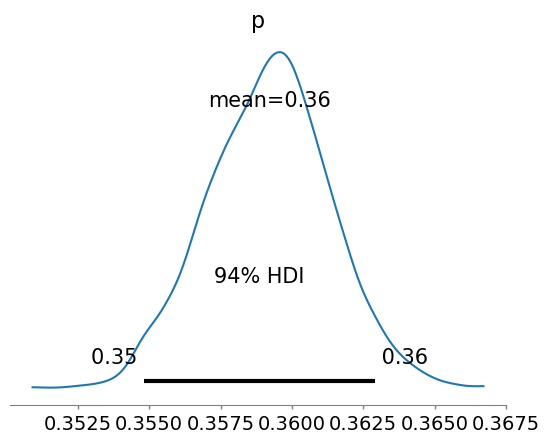

In [971]:
with pm.Model() as model:
    # Define the prior for the probability of heads (p)
    p = pm.Beta("p", alpha=1, beta=1)  # A uniform prior (alpha=1, beta=1)

    observed_data = pm.Binomial("observed_data", n=n_shots, p=p, observed=y) 

    # Sample from the posterior distribution
    trace = pm.sample(1000)

    # Print the posterior mean of p
    print(f"Posterior mean of p: {np.asarray(trace.posterior['p'].mean()):.2f}")

    # Visualize the posterior distribution
    az.plot_posterior(trace)


In [972]:
    print(f"Posterior mean of p: {np.asarray(trace.posterior['p'].mean())}")


Posterior mean of p: 0.35920621180317536


Sampling: [observed_data]


Output()

<Axes: xlabel='observed_data'>

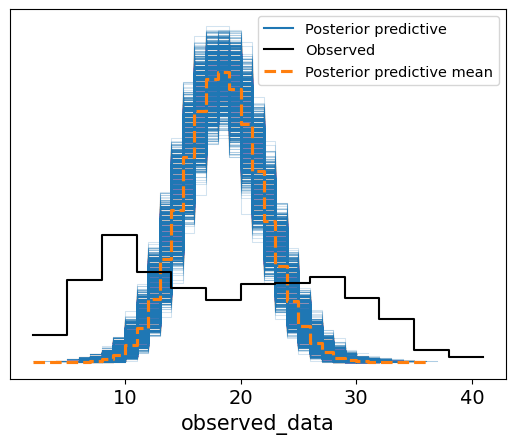

In [973]:
with model:
    pp = pm.sample_posterior_predictive(trace)

az.plot_ppc(pp)

In [1147]:

n_obs = len(data)
n_shots = 50

treatment = [False] * n_obs
gender = data.gender.astype('category').cat.codes.values

# Baseline free throw performance (number of successes out of 50)
baseline_successes = data.y0

# Treatment assignment (0 = control, 1 = treatment)

# Post-treatment free throw performance (number of successes out of 50)
#post_treatment_successes = np.where(treatment, data.y1, data.y0)
post_treatment_successes = data.y1

coords = {"gender": ["Male", "Female"], "treatment": [0, 1]}

# model
with pm.Model(coords=coords) as model:
    # Priors
    alpha = pm.Normal('alpha', mu=0, sigma=5)  
    beta = pm.Normal('beta', mu=0, sigma=5, dims="gender")   

    # Expected value of post-treatment performance
    mu = alpha + beta[gender] + baseline_successes / n_shots

    # Likelihood
    obs = pm.Binomial('obs', n=n_shots, p=pm.math.sigmoid(mu), observed=post_treatment_successes)

    # Inference
    trace = pm.sample()
    approx = pm.fit()

trace= approx.sample(2000)

# ATE estimation in terms of difference in success ratio
alpha_samples = np.asarray(trace.posterior['alpha'])
beta_samples = np.asarray(trace.posterior['beta'])
p_control = pm.math.sigmoid(alpha_samples).eval()
p_treatment = pm.math.sigmoid(alpha_samples + beta_samples).eval()
success_ratio_diff = p_treatment - p_control

print(f"Estimated difference in success ratio: {success_ratio_diff.mean():.4f} ± {success_ratio_diff.std():.4f}")

# Convert probabilities to expected number of successes
shots_control = p_control * n_shots
shots_treatment = p_treatment * n_shots

# Difference in expected number of successful shots
success_shots_diff = shots_treatment - shots_control

print(f"Estimated difference in number of successful shots: {success_shots_diff.mean():.4f} ± {success_shots_diff.std():.4f}")

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, treatment]
/Users/tarmo/miniforge3/envs/salk/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Output()

/Users/tarmo/miniforge3/envs/salk/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


Output()

Finished [100%]: Average Loss = 118.24


ValueError: operands could not be broadcast together with shapes (1,2000) (1,2000,2) 

array([<Axes: title={'center': 'alpha'}>,
       <Axes: title={'center': 'beta\nMale'}>,
       <Axes: title={'center': 'beta\nFemale'}>,
       <Axes: title={'center': 'treatment'}>], dtype=object)

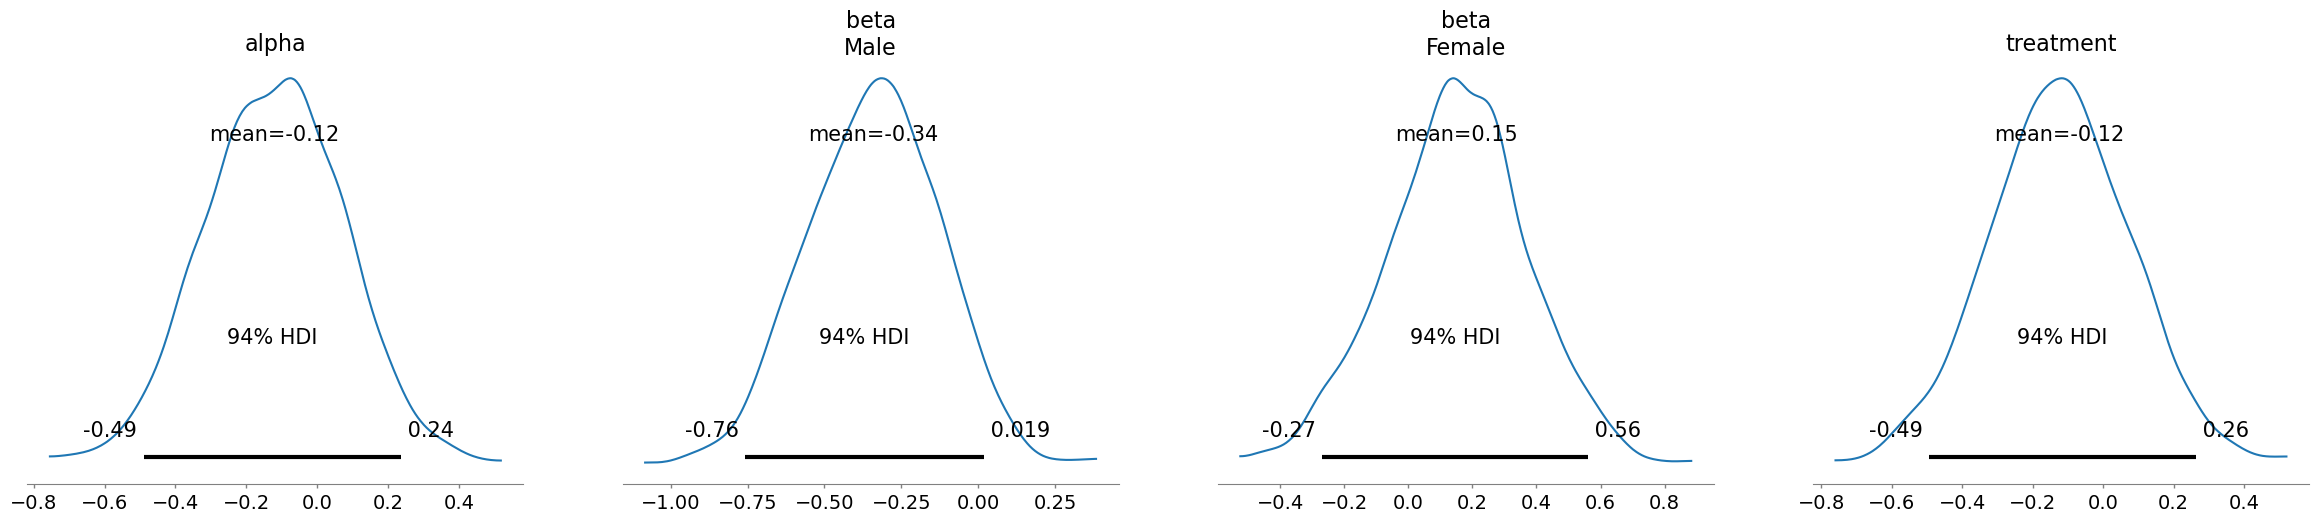

In [1148]:
pm.plot_posterior(trace)

Sampling: [obs]


Output()

<Axes: xlabel='obs'>

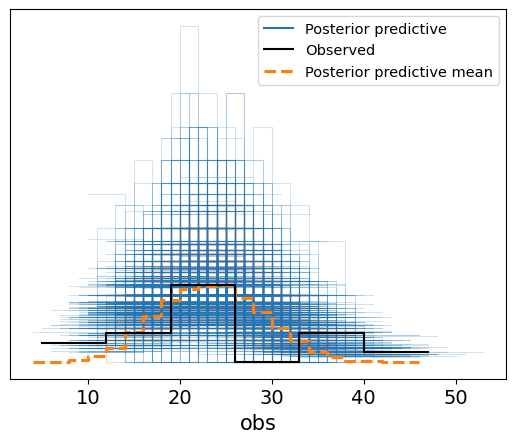

In [1144]:

with model:
    pp = pm.sample_posterior_predictive(trace) #(approx.sample()) 

pm.plot_ppc(pp)

In [1127]:
data #.groupby('gender').p_diff.mean()

,age,gender,athleticism,y0,y1,z,p0,p1,p_diff
0,24,Male,2,10,25,0,0.20,0.50,0.30
1,21,Male,7,3,15,0,0.06,0.30,0.24
2,28,Male,8,15,25,0,0.30,0.50,0.20
3,39,Male,7,10,40,0,0.20,0.80,0.60
4,31,Female,6,15,20,0,0.30,0.40,0.10
5,24,Female,7,16,36,0,0.32,0.72,0.40
6,26,Female,6,15,25,0,0.30,0.50,0.20
7,36,Male,6,10,20,0,0.20,0.40,0.20
8,29,Female,3,8,22,0,0.16,0.44,0.28
9,27,Female,2,5,15,0,0.10,0.30,0.20


In [1118]:
pp.posterior_predictive.obs.mean()

<xarray.DataArray 'obs' ()> Size: 8B
array(23.436)

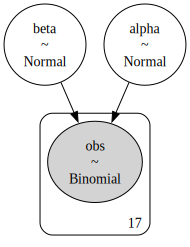

In [423]:
pm.model_to_graphviz(model)

In [1078]:
#np.random.seed(72)

x = data.athleticism

p_treat = invlogit(x - 5.5) # self-select bias
#p_treat = invlogit(-(x - 5.5)) #assigned selection
#z = np.random.binomial(1, p_treat)

z = np.random.binomial(1, 0.5, len(data)) # random selection

y = np.where(z == 1, y1, y0)

coords["predictors"] = ["z", "x"]

with pm.Model(coords=coords) as model:
    # Priors
    alpha = pm.Normal('alpha', mu=0, sigma=10)  
    beta = pm.Normal('beta', mu=0, sigma=10)   
    sigma = pm.HalfNormal('sigma', sigma=12)

    # Expected value of post-treatment performance
    mu = alpha + beta * z + y0 / n_shots

    # Likelihood
    obs = pm.Binomial('obs', n=n_shots, p=pm.math.sigmoid(mu), observed=y)

    # Inference
    trace = pm.sample(nuts_sampler='nutpie')

# ATE estimation in terms of difference in success ratio
alpha_samples = np.asarray(trace.posterior['alpha'])
beta_samples = np.asarray(trace.posterior['beta'])
p_control = pm.math.sigmoid(alpha_samples).eval()
p_treatment = pm.math.sigmoid(alpha_samples + beta_samples).eval()
success_ratio_diff = p_treatment - p_control

print(f"Estimated difference in success ratio: {success_ratio_diff.mean():.4f} ± {success_ratio_diff.std():.4f}")

# Convert probabilities to expected number of successes
shots_control = p_control * n_shots
shots_treatment = p_treatment * n_shots

# Difference in expected number of successful shots
success_shots_diff = shots_treatment - shots_control

print(f"Estimated difference in number of successful shots: {success_shots_diff.mean():.4f} ± {success_shots_diff.std():.4f}")


Progress,Draws,Divergences,Step Size,Gradients/Draw
,3000,0,0.71,7
,3000,2,0.72,7
,3000,1,0.68,7
,3000,0,0.67,3


Estimated difference in success ratio: 0.2369 ± 0.0304
Estimated difference in number of successful shots: 11.8471 ± 1.5225


Sampling: [obs]


Output()

<Axes: xlabel='obs'>

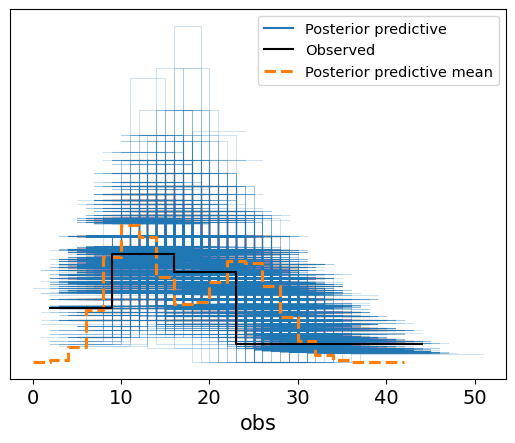

In [1079]:
with model:
    pp = pm.sample_posterior_predictive(trace)

pm.plot_ppc(pp)

In [1077]:
data['p0'] = data.y0 / 50
data['p1'] = data.y1 / 50

(data.p1-data.p0).mean()

0.25647058823529406

In [1074]:
data['z'] = 0
(data[data.z==0].y1 - data[data.z==0].y0).mean()

12.823529411764707

array([<Axes: title={'center': 'alpha'}>,
       <Axes: title={'center': 'beta'}>,
       <Axes: title={'center': 'sigma'}>,
       <Axes: title={'center': 'sigma_log__'}>], dtype=object)

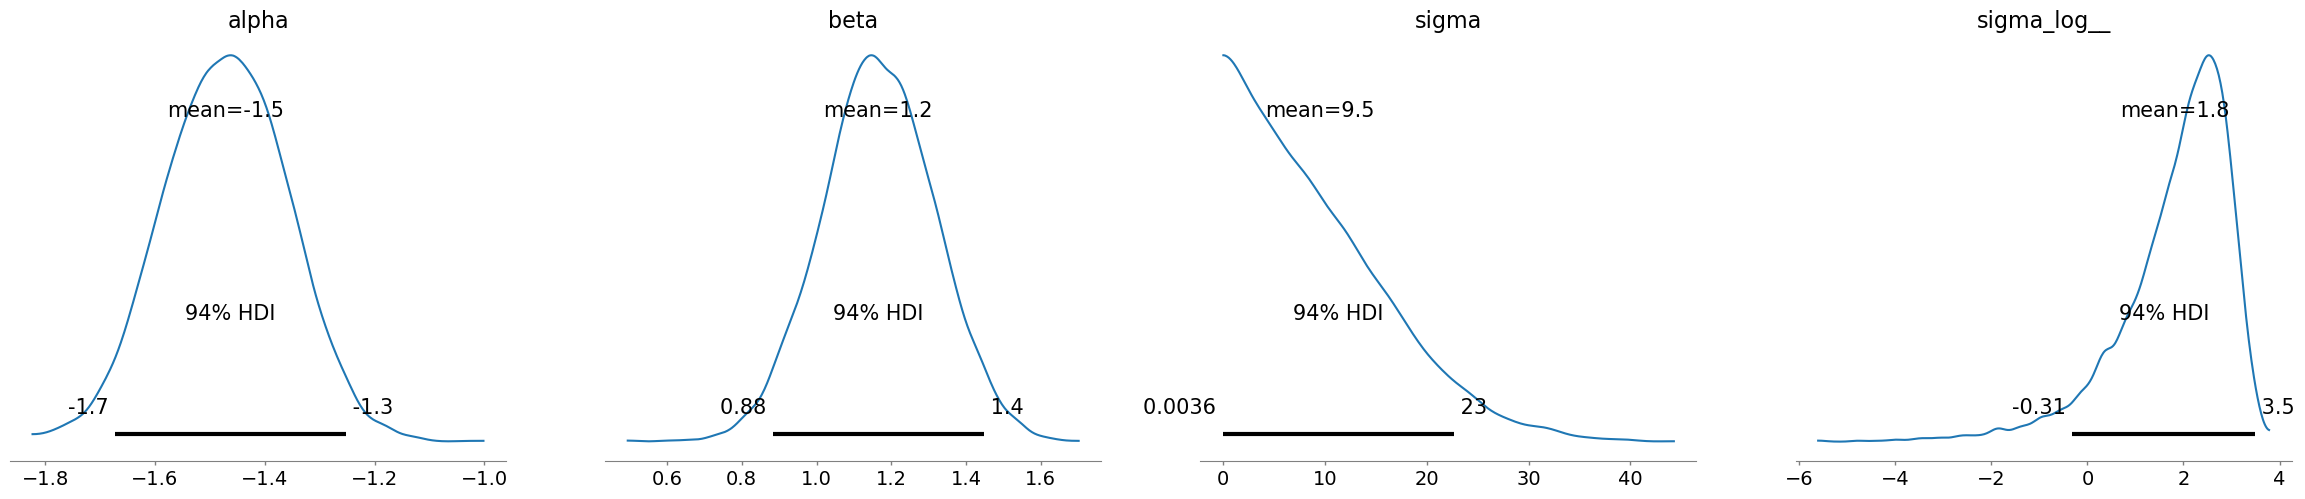

In [984]:
pm.plot_posterior(trace)

In [231]:
treatment = np.ones(17)
post_treatment_successes = data.y1
baseline_successes = data.y0




array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [304]:
y = data.y1
x = np.ones(17)

with pm.Model() as model:
    # Priors
    alpha = pm.Normal('alpha', mu=0, sigma=10)  
    beta = pm.Normal('beta', mu=0, sigma=10)   
    sigma = pm.HalfNormal('sigma', sigma=10)

    # Expected value of post-treatment performance
    mu = alpha + beta * z + data.y0 / n_shots

    # Likelihood
    obs = pm.Binomial('obs', n=n_shots, p=pm.math.sigmoid(mu), observed=data.y1)

    # Inference
    trace = pm.sample(2000, tune=1000)

# ATE estimation in terms of difference in success ratio
alpha_samples = np.asarray(trace.posterior['alpha'])
beta_samples = np.asarray(trace.posterior['beta'])
p_control = pm.math.sigmoid(alpha_samples).eval()
p_treatment = pm.math.sigmoid(alpha_samples + beta_samples).eval()
success_ratio_diff = p_treatment - p_control

ate_ratio = az.summary(trace, var_names=['beta'])

print(ate_ratio)
print(f"Estimated difference in success ratio: {success_ratio_diff.mean():.4f} ± {success_ratio_diff.std():.4f}")



Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.


       mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
beta  0.646  0.139   0.395    0.923      0.002    0.002    3198.0    3952.0   

      r_hat  
beta    1.0  
Estimated difference in success ratio: 0.1552 ± 0.0331


In [305]:
# Convert probabilities to expected number of successes
shots_control = p_control * n_shots
shots_treatment = p_treatment * n_shots

# Difference in expected number of successful shots
success_shots_diff = shots_treatment - shots_control

ate_ratio = az.summary(trace, var_names=['beta'])

print(ate_ratio)
print(f"Estimated difference in number of successful shots: {success_shots_diff.mean():.4f} ± {success_shots_diff.std():.4f}")


       mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
beta  0.646  0.139   0.395    0.923      0.002    0.002    3198.0    3952.0   

      r_hat  
beta    1.0  
Estimated difference in number of successful shots: 7.7621 ± 1.6554


In [303]:
import pymc as pm
import numpy as np
import arviz as az

# Simulated data (replace with actual data)
n_obs = 1000
n_shots = 50

# Baseline free throw performance (number of successes out of 50)
baseline_successes = np.random.randint(10, 40, size=n_obs)

# Treatment assignment (0 = control, 1 = treatment)
treatment = np.random.randint(0, 2, size=n_obs)

# Post-treatment free throw performance (number of successes out of 50)
post_treatment_successes = baseline_successes + treatment * np.random.randint(-2, 10, size=n_obs)
post_treatment_successes = np.clip(post_treatment_successes, 0, n_shots)

# PyMC model
with pm.Model() as model:
    # Priors
    alpha = pm.Normal('alpha', mu=0, sigma=10)  # Intercept
    beta = pm.Normal('beta', mu=0, sigma=10)   # Effect of treatment
    sigma = pm.HalfNormal('sigma', sigma=10)

    # Expected value of post-treatment performance
    mu = alpha + beta * treatment + baseline_successes / n_shots

    # Likelihood
    obs = pm.Binomial('obs', n=n_shots, p=pm.math.sigmoid(mu), observed=post_treatment_successes)

    # Inference
    trace = pm.sample(2000, tune=1000)

# ATE estimation in terms of difference in success ratio
alpha_samples = np.asarray(trace.posterior['alpha'])
beta_samples = np.asarray(trace.posterior['beta'])
p_control = pm.math.sigmoid(alpha_samples).eval()
p_treatment = pm.math.sigmoid(alpha_samples + beta_samples).eval()
success_ratio_diff = p_treatment - p_control

ate_ratio = az.summary(trace, var_names=['beta'])

print(ate_ratio)
print(f"Estimated difference in success ratio: {success_ratio_diff.mean():.4f} ± {success_ratio_diff.std():.4f}")



Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


       mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
beta  0.255  0.018   0.222    0.289        0.0      0.0    2993.0    4178.0   

      r_hat  
beta    1.0  
Estimated difference in success ratio: 0.0611 ± 0.0043


In [365]:
baseline_successes.mean()

24.229

In [522]:
alpha = 4.6
beta = 1.9

with pm.Model() as model4:
    mu_A = pm.Gamma('mu_A', alpha, beta)
    mu_B = pm.Gamma('mu_B', alpha, beta)
    goals_A = pm.Poisson('goals_A', mu_A, observed=[5, 1, 4])
    goals_B = pm.Poisson('goals_B', mu_B, observed=[1, 3, 3])

    trace = pm.sample()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_A, mu_B]
/Users/tarmo/miniforge3/envs/salk/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Output()

/Users/tarmo/miniforge3/envs/salk/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.


In [523]:
mu_A = trace.posterior['mu_A']
mu_B = trace.posterior['mu_B']
mu_B.mean(), mu_A.mean()

(<xarray.DataArray 'mu_B' ()> Size: 8B
 array(2.36052042),
 <xarray.DataArray 'mu_A' ()> Size: 8B
 array(2.97845302))

In [524]:
print(f"{(mu_A > mu_B).mean():.1%}")

71.2%


In [525]:
with model4:
    pp = pm.sample_posterior_predictive(trace)

pp

Sampling: [goals_A, goals_B]


Output()

Inference data with groups:
	> posterior_predictive
	> observed_data

In [541]:
(pp.posterior_predictive['goals_A'].values.flatten() - pp.posterior_predictive['goals_B'].values.flatten()).mean()

0.625

In [545]:
data

,age,gender,athleticism,y0,y1
0,24,Male,2,10,25
1,21,Male,7,3,15
2,28,Male,8,15,25
3,39,Male,7,10,40
4,31,Female,6,15,20
5,24,Female,7,16,36
6,26,Female,6,15,25
7,36,Male,6,10,20
8,29,Female,3,8,22
9,27,Female,2,5,15


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambda_pre, theta]
/Users/tarmo/miniforge3/envs/salk/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Output()

/Users/tarmo/miniforge3/envs/salk/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


<Axes: title={'center': 'theta'}>

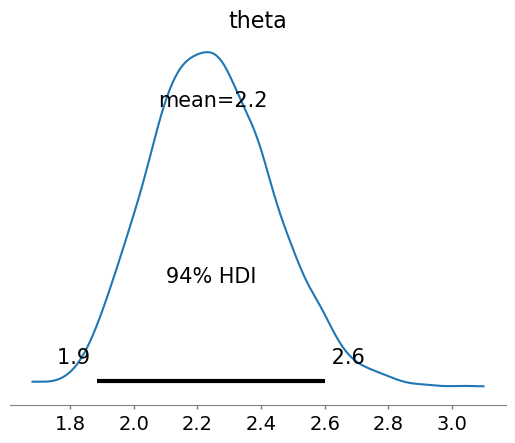

In [1149]:
### POISSON PROCESS EXAMPLE

import pymc as pm
import numpy as np
import arviz as az

# Simulated data
n_players = len(data)  # Number of players
shots_attempted = 50  # Each player takes 50 shots

# Selection to treatment based on athleticism
p_treat = invlogit(athleticism - 5.5)

treatment_assignment = np.ones(n_players) #all treated
#treatment_assignment = np.random.binomial(1, 0.5, size=n_players) #random treatment
#treatment_assignment = np.random.binomial(1, p_treat) #biased treatment

y_pre = data.y0
y_post = np.where(treatment_assignment == 1, data.y1, data.y0)

coords = {}

# PyMC Model
with pm.Model() as model:
    
    # Prior for baseline ability
    lambda_pre = pm.Gamma("lambda_pre", alpha=1, beta=5, shape=n_players)
    #lambda_pre = pm.Uniform("lambda_pre", 0, 50, shape=n_players)
    
    # Treatment effect
    theta = pm.LogNormal("theta", mu=0, sigma=1)
    #theta = pm.TruncatedNormal("theta", mu=0, sigma=10, lower=-lambda_pre)
    
    # Post-treatment lambda
    #lambda_post = pm.Deterministic("lambda_post", lambda_pre * theta)
    lambda_post = pm.Deterministic("lambda_post", lambda_pre * (1 + treatment_assignment * (theta - 1)))
    #lambda_post = pm.Deterministic("lambda_post", lambda_pre + (treatment_assignment * theta))

    
    # Likelihood for pre- and post-treatment shots
    y_pre_obs = pm.Poisson("y_pre_obs", mu=lambda_pre * shots_attempted, observed=y_pre)
    y_post_obs = pm.Poisson("y_post_obs", mu=lambda_post * shots_attempted, observed=y_post)
    
    trace = pm.sample()

# Summary
pm.plot_posterior(trace, var_names='theta')
#az.summary(trace) #, var_names=["theta"])


In [1150]:
pm.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
lambda_post[0],0.482,0.080,0.327,0.630,0.001,0.001,8538.0,3305.0,1.00
lambda_post[1],0.254,0.059,0.147,0.363,0.001,0.001,7101.0,3172.0,1.00
lambda_post[2],0.549,0.086,0.397,0.717,0.001,0.001,7710.0,3347.0,1.00
lambda_post[3],0.683,0.094,0.506,0.857,0.001,0.001,8213.0,3306.0,1.00
lambda_post[4],0.482,0.078,0.340,0.629,0.001,0.001,7416.0,3179.0,1.00
lambda_post[5],0.710,0.102,0.529,0.909,0.001,0.002,7686.0,2185.0,1.00
lambda_post[6],0.549,0.086,0.393,0.716,0.001,0.001,7192.0,2604.0,1.00
lambda_post[7],0.415,0.075,0.278,0.555,0.001,0.001,8849.0,2780.0,1.01
lambda_post[8],0.415,0.075,0.278,0.557,0.001,0.001,8740.0,3094.0,1.00
lambda_post[9],0.281,0.061,0.170,0.392,0.001,0.001,8642.0,2959.0,1.00


Sampling: [y_post_obs, y_pre_obs]


Output()

/var/folders/2z/7k7z_91s1y50t4lpv5jlllpm0000gn/T/ipykernel_67199/1399359731.py:16: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_95 = az.hdi(ate, hdi_prob=0.95).mean(axis=0)


Expected improvement in successful shots: 15.68
95% HDI: (12.86, 18.57)


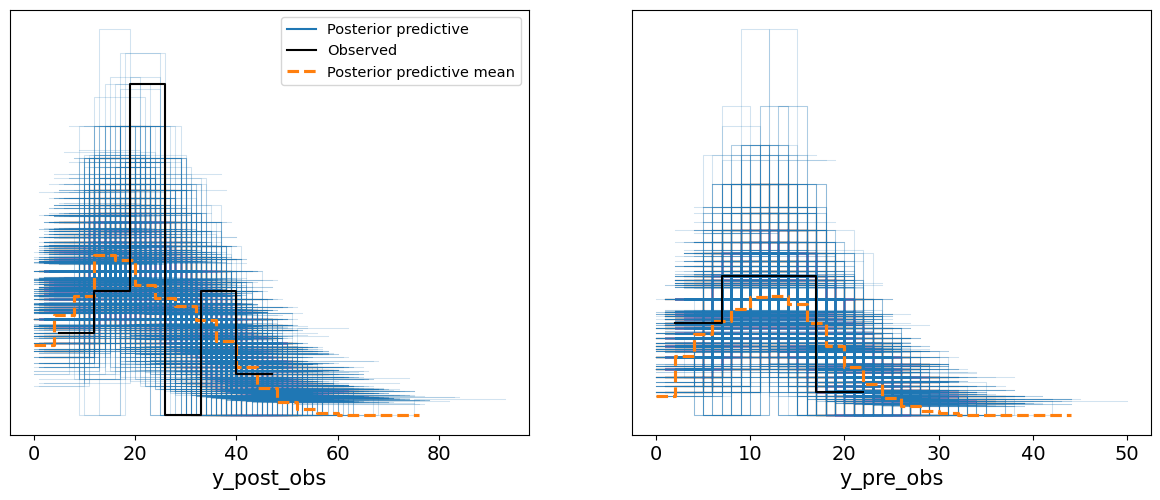

In [1168]:
with model:
    pp = pm.sample_posterior_predictive(trace, var_names=["y_pre_obs", "y_post_obs"])

y_pre_pred = pp.posterior_predictive["y_pre_obs"].values  
y_post_pred = pp.posterior_predictive["y_post_obs"].values  

# Calculate the improvement (post-treatment - pre-treatment) for each player and each sample
improvement_pred = (y_post_pred - y_pre_pred) # * np.broadcast_to(treatment_assignment, (4, 1000, 17))

treated_mask = treatment_assignment.astype(bool)  

improvement_pred_treated = improvement_pred[:, :, treated_mask] 
ate = improvement_pred_treated.mean(axis=2)

# Compute the 95% HDI using Arviz's hdi function
hdi_95 = az.hdi(ate, hdi_prob=0.95).mean(axis=0)

# Extract the lower and upper bounds of the HDI
hdi_lower, hdi_upper = hdi_95[0], hdi_95[1]

az.plot_ppc(pp)

print(f"Expected improvement in successful shots: {np.mean(ate):.2f}")
print(f"95% HDI: ({hdi_lower:.2f}, {hdi_upper:.2f})")


<Axes: xlabel='y1', ylabel='athleticism'>

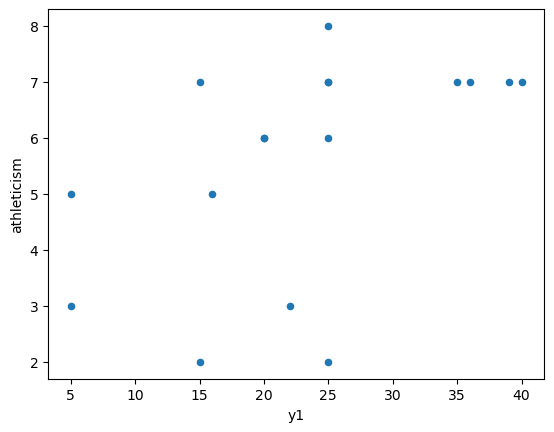

In [992]:
data['delta'] = data.y1 - data.y0

data.plot.scatter('y1', 'athleticism')

In [932]:
data['lambda_pre'] = y0/50
data['treatment'] = treatment_assignment

print(f'treated ATE: {(data[data.treatment==1].y1-data[data.treatment==1].y0).mean():.2f}')

data

treated ATE: 15.67


,age,gender,athleticism,y0,y1,lambda_pre,treatment
0,24,Male,2,10,25,0.20,0
1,21,Male,7,3,15,0.06,0
2,28,Male,8,15,25,0.30,1
3,39,Male,7,10,40,0.20,1
4,31,Female,6,15,20,0.30,0
5,24,Female,7,16,36,0.32,1
6,26,Female,6,15,25,0.30,1
7,36,Male,6,10,20,0.20,0
8,29,Female,3,8,22,0.16,0
9,27,Female,2,5,15,0.10,0


/Users/tarmo/miniforge3/envs/salk/lib/python3.12/site-packages/pymc/data.py:235: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambda_pre, theta]
/Users/tarmo/miniforge3/envs/salk/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Output()

/Users/tarmo/miniforge3/envs/salk/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


<Axes: title={'center': 'theta'}>

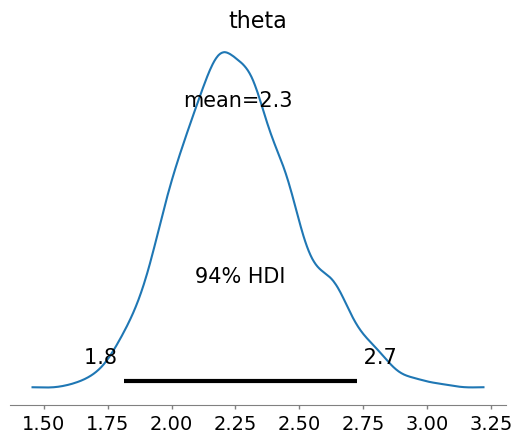

In [ ]:
# Define coordinates
coords = {
    "player": np.arange(n_players),  # Index for players
    "treatment": [1, 0]  # Treatment categories (control=0, treated=1)
}

treatment_assignment = np.random.binomial(1, p_treat) #biased treatment

# PyMC Model
with pm.Model(coords=coords) as model:
    # Specify dimension names for your variables
    lambda_pre = pm.Gamma("lambda_pre", alpha=1, beta=5, 
                         dims="player")  # shape=n_players
    
    theta = pm.LogNormal("theta", mu=0, sigma=1)
    
    lambda_post = pm.Deterministic("lambda_post", 
                                  lambda_pre * (1 + treatment_assignment * (theta - 1)), 
                                  dims="player")
    
    # Add observed data with dimensions
    y_pre_obs = pm.Poisson("y_pre_obs", 
                          mu=lambda_pre * shots_attempted, 
                          observed=y_pre,
                          dims="player")
    
    y_post_obs = pm.Poisson("y_post_obs", 
                           mu=lambda_post * shots_attempted, 
                           observed=y_post,
                           dims="player")
    
    # Add treatment assignment as a constant to the trace
    pm.Data("treatment_assignment", treatment_assignment, dims="player")
    
    trace = pm.sample()

# Now you can use coordinates for analysis
pm.plot_posterior(trace, var_names='theta')

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

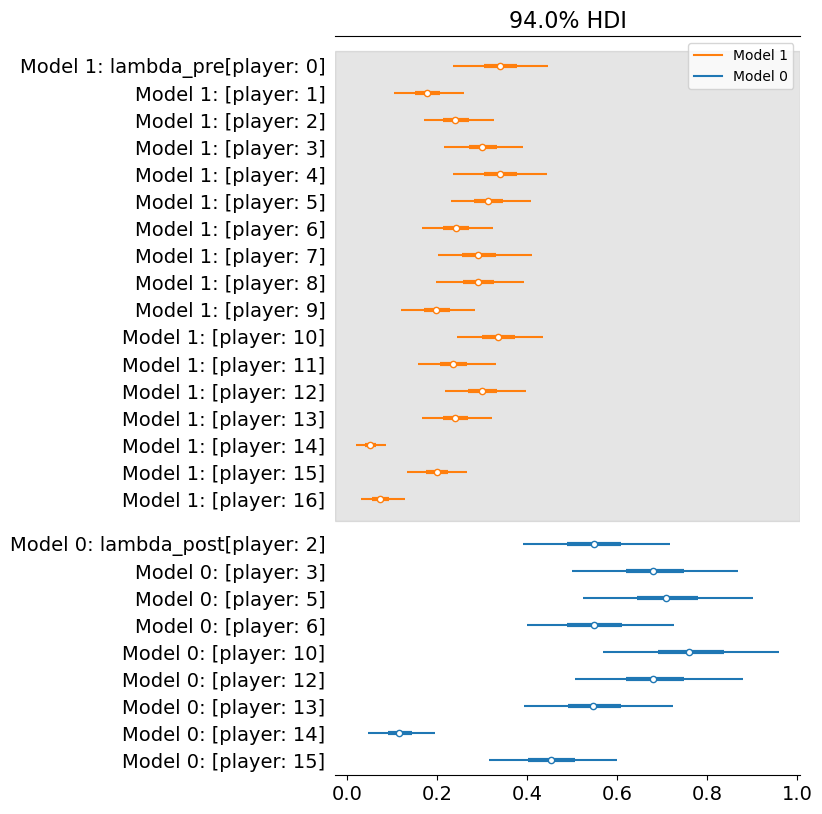

In [928]:
# Convert trace to InferenceData
#idata = az.from_pymc(trace)

# Get posterior for treated players
treated_players = trace.constant_data.treatment_assignment == 1
lambda_post_treated = trace.posterior.lambda_post.sel(player=treated_players)

# Compare treated vs control
az.plot_forest([lambda_post_treated, trace.posterior.lambda_pre], 
              combined=True, 
              labeller=az.labels.DimCoordLabeller())

In [1180]:
import pymc as pm
import numpy as np

n_players = len(data)

# Assuming you have these variables defined:
# n_players, p_treat, shots_attempted, y_pre, y_post
# And a gender array (0 for male, 1 for female or similar binary coding)

# Define coordinates
coords = {
    "player": np.arange(n_players),  # Index for players
    "treatment": [1, 0],  # Treatment categories (control=0, treated=1)
    "gender": [0, 1]  # Gender categories
}

treatment_assignment = np.random.binomial(1, p_treat) #biased treatment

# PyMC Model
with pm.Model(coords=coords) as model:
    # Specify dimension names for your variables
    lambda_pre = pm.Gamma("lambda_pre", alpha=1, beta=5, 
                         dims="player")  # shape=n_players
    
    # Gender-specific treatment effects
    theta_male = pm.LogNormal("theta_male", mu=0, sigma=1)
    theta_female = pm.LogNormal("theta_female", mu=0, sigma=1)
    
    # Create a gender indicator vector (assuming gender is a 0/1 variable)
    # gender_vector should be a numpy array of 0s and 1s indicating gender for each player
    #ender_vector = gender  # assuming 'gender' is defined in your data
    
    # Combine the effects based on gender
    theta_combined = theta_male * (1 - gender) + theta_female * gender
    
    lambda_post = pm.Deterministic("lambda_post", 
                                  lambda_pre * (1 + treatment_assignment * (theta_combined - 1)), 
                                  dims="player")
    
    # Add observed data with dimensions
    y_pre_obs = pm.Poisson("y_pre_obs", 
                          mu=lambda_pre * shots_attempted, 
                          observed=y_pre,
                          dims="player")
    
    y_post_obs = pm.Poisson("y_post_obs", 
                           mu=lambda_post * shots_attempted, 
                           observed=y_post,
                           dims="player")
    
    # Add treatment assignment and gender as constants to the trace
    pm.Data("treatment_assignment", treatment_assignment, dims="player")
    pm.Data("gender", gender, dims="player")
    
    # Compute the difference between gender effects
    theta_diff = pm.Deterministic("theta_diff", theta_female - theta_male)
    
    trace = pm.sample()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambda_pre, theta_male, theta_female]
/Users/tarmo/miniforge3/envs/salk/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Output()

/Users/tarmo/miniforge3/envs/salk/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [1171]:
pm.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
lambda_post[0],0.342,0.056,0.240,0.448,0.001,0.001,7241.0,2478.0,1.0
lambda_post[1],0.262,0.062,0.151,0.377,0.001,0.001,8152.0,2822.0,1.0
lambda_post[2],0.566,0.092,0.394,0.744,0.001,0.001,7338.0,2536.0,1.0
lambda_post[3],0.705,0.104,0.500,0.889,0.001,0.001,5503.0,3434.0,1.0
lambda_post[4],0.345,0.056,0.246,0.459,0.001,0.001,7813.0,2606.0,1.0
lambda_post[5],0.695,0.105,0.498,0.889,0.001,0.002,5622.0,3062.0,1.0
lambda_post[6],0.538,0.091,0.377,0.714,0.001,0.001,6635.0,3210.0,1.0
lambda_post[7],0.296,0.053,0.202,0.395,0.001,0.001,8369.0,3176.0,1.0
lambda_post[8],0.294,0.055,0.196,0.399,0.001,0.001,6866.0,2770.0,1.0
lambda_post[9],0.200,0.044,0.120,0.283,0.000,0.001,9093.0,3120.0,1.0


Sampling: [y_post_obs, y_pre_obs]


Output()

array([<Axes: xlabel='y_post_obs'>, <Axes: xlabel='y_pre_obs'>],
      dtype=object)

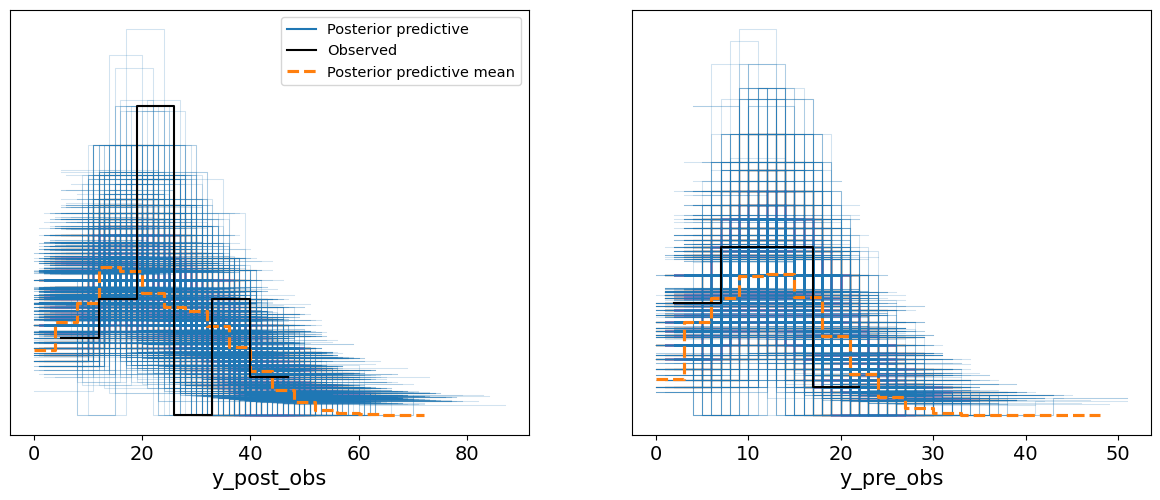

In [1167]:
with model:
    pp = pm.sample_posterior_predictive(trace)

pm.plot_ppc(pp)

In [1001]:
def scale_values(s):
    return (s - s.mean()) / s.std()

data = pd.read_csv('../bayes/data/drug_consumption_transformed.csv')

levels = ['CL0', 'CL1', 'CL2', 'CL3', 'CL4', 'CL5', 'CL6']
use_dict = dict(zip(levels, range(len(levels))))

data.loc[:, 'Alcohol':'VSA'] = data.loc[:, 'Alcohol':'VSA'].replace(use_dict).infer_objects(copy=False)

predictors = data.loc[:, 'Nscore':'SS'].apply(scale_values)
predictors['Gender'] = data.Gender.apply(lambda x: 1 if x=='M' else 0)
p_cols = predictors.columns

X_train = predictors



/var/folders/2z/7k7z_91s1y50t4lpv5jlllpm0000gn/T/ipykernel_67199/4273814913.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data.loc[:, 'Alcohol':'VSA'] = data.loc[:, 'Alcohol':'VSA'].replace(use_dict).infer_objects(copy=False)


In [1087]:
data['p_diff'] = data.p1 - data.p0

data

,age,gender,athleticism,y0,y1,z,p0,p1,p_diff
0,24,Male,2,10,25,0,0.20,0.50,0.30
1,21,Male,7,3,15,0,0.06,0.30,0.24
2,28,Male,8,15,25,0,0.30,0.50,0.20
3,39,Male,7,10,40,0,0.20,0.80,0.60
4,31,Female,6,15,20,0,0.30,0.40,0.10
5,24,Female,7,16,36,0,0.32,0.72,0.40
6,26,Female,6,15,25,0,0.30,0.50,0.20
7,36,Male,6,10,20,0,0.20,0.40,0.20
8,29,Female,3,8,22,0,0.16,0.44,0.28
9,27,Female,2,5,15,0,0.10,0.30,0.20
